# Example for computing TCs with multiple processes

In this example, we slightly adapt the DNN example to illustrate the TC computation on multiple CPU cores in parallel.
Main take-aways:
- your model class has to be extended by the TC module by inheritance
- the TC module will use multiple processes to calculate TCs in parallel, they still run on the same device (e.g. cpu, cuda:0)

So let's start in the same way as in our DNN example..

In [9]:
import torch
import matplotlib.pyplot as plt
import itertools

from torch import nn
from helpers import gen_data, plot_data, get_feature_combis
from tayloranalysis.model_extension import BaseTaylorAnalysis

### Setup Data

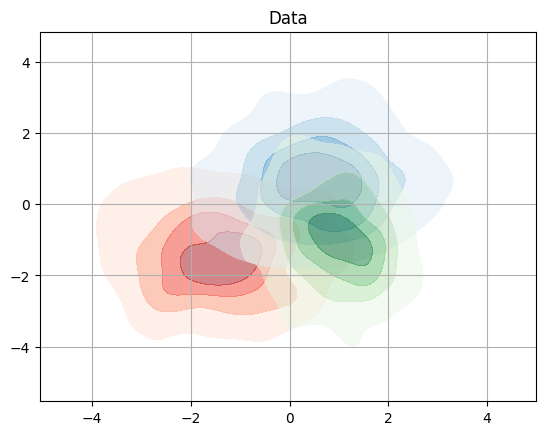

In [10]:
names = ["x1", "x2"]
x_train, y_train = gen_data(400)
x_test, y_test = gen_data(400)
plot_data(x_train, y_train)  

In [11]:
x_test, y_test, x_train, y_train = map(
    lambda x: torch.tensor(x).float(),
    (x_test, y_test, x_train, y_train),
)

# one hot encode y train
y_train = nn.functional.one_hot(y_train.to(torch.int64), 3).float()

### Setup Model and TaylorAnalysis tool

In [12]:
def reduce(x: torch.Tensor):
    return torch.mean(x).cpu().detach().numpy()

Now extend an exemplary `Mlp` with the TaylorAnalysis functionality by inheriting from the `BaseTaylorAnalysis` class.


In [13]:
class Mlp(nn.Module, BaseTaylorAnalysis):
    def __init__(self, input_neurons, hidden_neurons, output_neurons, hiddenlayers):

        nn.Module.__init__(self)
        #BaseTaylorAnalysis.__init__(self)

        # mlp layers
        self.mlplayers = nn.ModuleList([nn.Linear(input_neurons, hidden_neurons)])
        self.mlplayers.extend(
            [nn.Linear(hidden_neurons, hidden_neurons) for i in range(hiddenlayers + 1)]
        )
        self.mlplayers.append(nn.Linear(hidden_neurons, output_neurons))

    def forward(self, x):
        # input shape: (batch, features)
        for mlplayer in self.mlplayers[:-1]:
            x = mlplayer(x)
            x = torch.tanh(x)

        # new x: (batch, 1)
        x = self.mlplayers[-1](x)
        x = x.squeeze(-1)  # new x: (batch)
        x = torch.sigmoid(x)
        return x

model = Mlp(input_neurons=2, hidden_neurons=20, output_neurons=3, hiddenlayers=2)

In [14]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)
crit = nn.CrossEntropyLoss()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
x_train = x_train.to(device)
y_train = y_train.to(device)
model.to(device)

Mlp(
  (mlplayers): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1-3): 3 x Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=3, bias=True)
  )
)

In [15]:
combinations = [(0,), (1,)]  # 1st order taylor coefficients
combinations += [
    i for i in itertools.permutations([0, 1], 2)
]  # 2nd order taylor coefficients
combinations += [(0, 1, 1)]  # exemplary 3rd order taylor coefficient
combinations

[(0,), (1,), (0, 1), (1, 0), (0, 1, 1)]

### Training loop with Multiprocessing

The training loop is build up in the same way as in the DNN example. 
To use multiprocessing, you have to set `use_parallelization=3`, where `3` corresponds to three processes.

In [16]:
if __name__ == "__main__":
    tcs_training = []
    x_train.requires_grad = True
    for epoch in range(250):
        optim.zero_grad()
        pred = model(x_train)
        loss = crit(pred, y_train)
        loss.backward()
        optim.step()

        if epoch % 10 == 0:
            print("Epoch {}: Loss: {:.3f}".format(epoch + 1, loss))

        tc_dict = model.get_tc(
            "x",
            forward_kwargs={"x": x_test.to(device)},
            tc_idx_list=combinations,
            reduce_func=reduce,
            use_parallelization=3,
            )
        # here we directly unpack the dictionary values into a list
        tcs_training.append(list(tc_dict.values()))

Epoch 1: Loss: 1.100


Process SpawnPoolWorker-9:
Traceback (most recent call last):
  File "/usr/lib64/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib64/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib64/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'Mlp' on <module '__main__' (built-in)>
Process SpawnPoolWorker-10:
Traceback (most recent call last):
  File "/usr/lib64/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib64/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib64/python3.8/multiprocessing/queues.py", line 358, 

KeyboardInterrupt: 

### Evaluation

Get the combinations with feature names instead of feature numbers for plotting. Have a look at the `get_feature_combis` function!

In [ ]:
labels = get_feature_combis(names, combinations)
labels = [",".join(label) for label in labels]
labels

Have a look at the development of the taylorcoefficients during the training!

In [ ]:

if __name__ == "__main__":
    plt.title("Taylor Coefficients during Training for given Features")
    plt.plot(tcs_training, label=labels)
    plt.xlabel("Epoch")
    plt.ylabel("Taylor Coefficient Value")
    plt.legend()
    plt.show()

In [ ]:

if __name__ == "__main__":
    # get a set of target taylor coefficients after training
    model.cpu()
    tc_dict = model.get_tc(
        "x",
        forward_kwargs={"x": x_test},
        tc_idx_list=combinations,
        reduce_func=reduce)

    # plot tcs after training
    plt.title("Taylor Coefficients after Training for given Features")
    plt.plot(labels, list(tc_dict.values()), "+", color="black", markersize=10)
    plt.xlabel("Taylor Coefficient")
    plt.ylabel("Taylor Coefficient Value")
    plt.show()